In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
def find_best_threshold(thresholds, fpr, tpr):
    """
    find the best threshold from the roc curve. by finding the threshold for the point which is closest to (fpr=0,tpr=1)
    """
    fpr_tpr = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr, 'tpr': tpr})
    fpr_tpr['dist'] = (fpr_tpr['fpr'])**2 + (fpr_tpr['tpr']-1)**2
    return fpr_tpr.loc[fpr_tpr.dist.idxmin(), 'thresholds']


def get_model_results(model, train, test, y_train, y_test):
    """Plotting the ROC curves"""
    probabilities = model.predict_proba(test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    threshold = find_best_threshold(thresholds, fpr, tpr)
    predictions = probabilities>threshold
    plt.figure()
    plt.plot(fpr, tpr, label='test')
    roc_auc = roc_auc_score(y_test, probabilities)
    probabilities = model.predict_proba(train)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, probabilities)
    plt.plot(fpr, tpr, label='train')
    plt.plot([0, 1], [0, 1], 'r--', label='random guess')
    plt.title("area under the ROC curve = {:.3f}".format(roc_auc), fontsize=18);
    print(classification_report(y_test, predictions))
    plt.legend()
    
def tree_auc(train, test, y_train, y_test,tree_size=50, types='random_forest'):
    """Calculating auc for model with a different tree size
       param type: choose between decision_tree or random_forest
       Returns a dictionary with results."""
    result_dict = {}
    for i in range(1, tree_size):
        if types == 'random_forest':
            model = RandomForestClassifier(n_estimators=10, max_depth=i,random_state=42)
            model.fit(train, y_train)
        elif types == 'decision_tree':
            model = tree.DecisionTreeClassifier(max_depth=i, random_state=42)
            model.fit(train, y_train)
            
        probabilities = model.predict_proba(test)[:,1]
        roc_auc = roc_auc_score(y_test, probabilities)
        result_dict[i] =  1- roc_auc
    return result_dict

def plot_tree_auc(forest_results, tree_results):
    """Plotting tree size vs misclassification rates for random forest and decision tree"""
    sns.set()
    f = plt.figure(figsize=(8,12))
    plt.plot(forest_dict.keys(), forest_dict.values(), label='Random forest', c='blue', alpha=0.3, linewidth=3 )
    plt.plot(tree_dict.keys(), tree_dict.values(), 'r--', label='decision tree', c='black', alpha=0.3)
    plt.xlabel('Tree size')
    plt.ylabel('Misclassification rate')
    plt.legend()
    plt.show()


In [3]:
#read data
data = pd.read_csv('spambase.data', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


#### Part 1

In [4]:
#Fill missing values
data = data.fillna(0)

print('Number of missing values: ',data.isnull().sum().sum())

Number of missing values:  0


In [5]:
print(data.shape)

(4601, 58)


Comment: We have 4601 rows/data points and 57 predicting features and 1 predicted feature(spam/ham)

0    2788
1    1813
Name: 57, dtype: int64


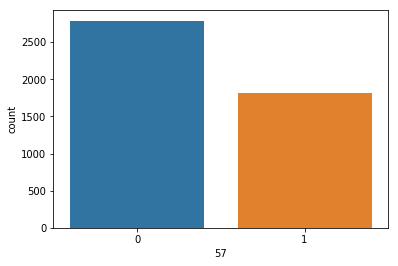

In [6]:
y = data.iloc[:, 57]
X = data.iloc[:, :57]
print(y.value_counts())
sns.countplot(y);

Comment: 2788 spam instances vs 1813 ham instances

In [7]:
#Splitting to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Plot the train dataset tree

In [8]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)

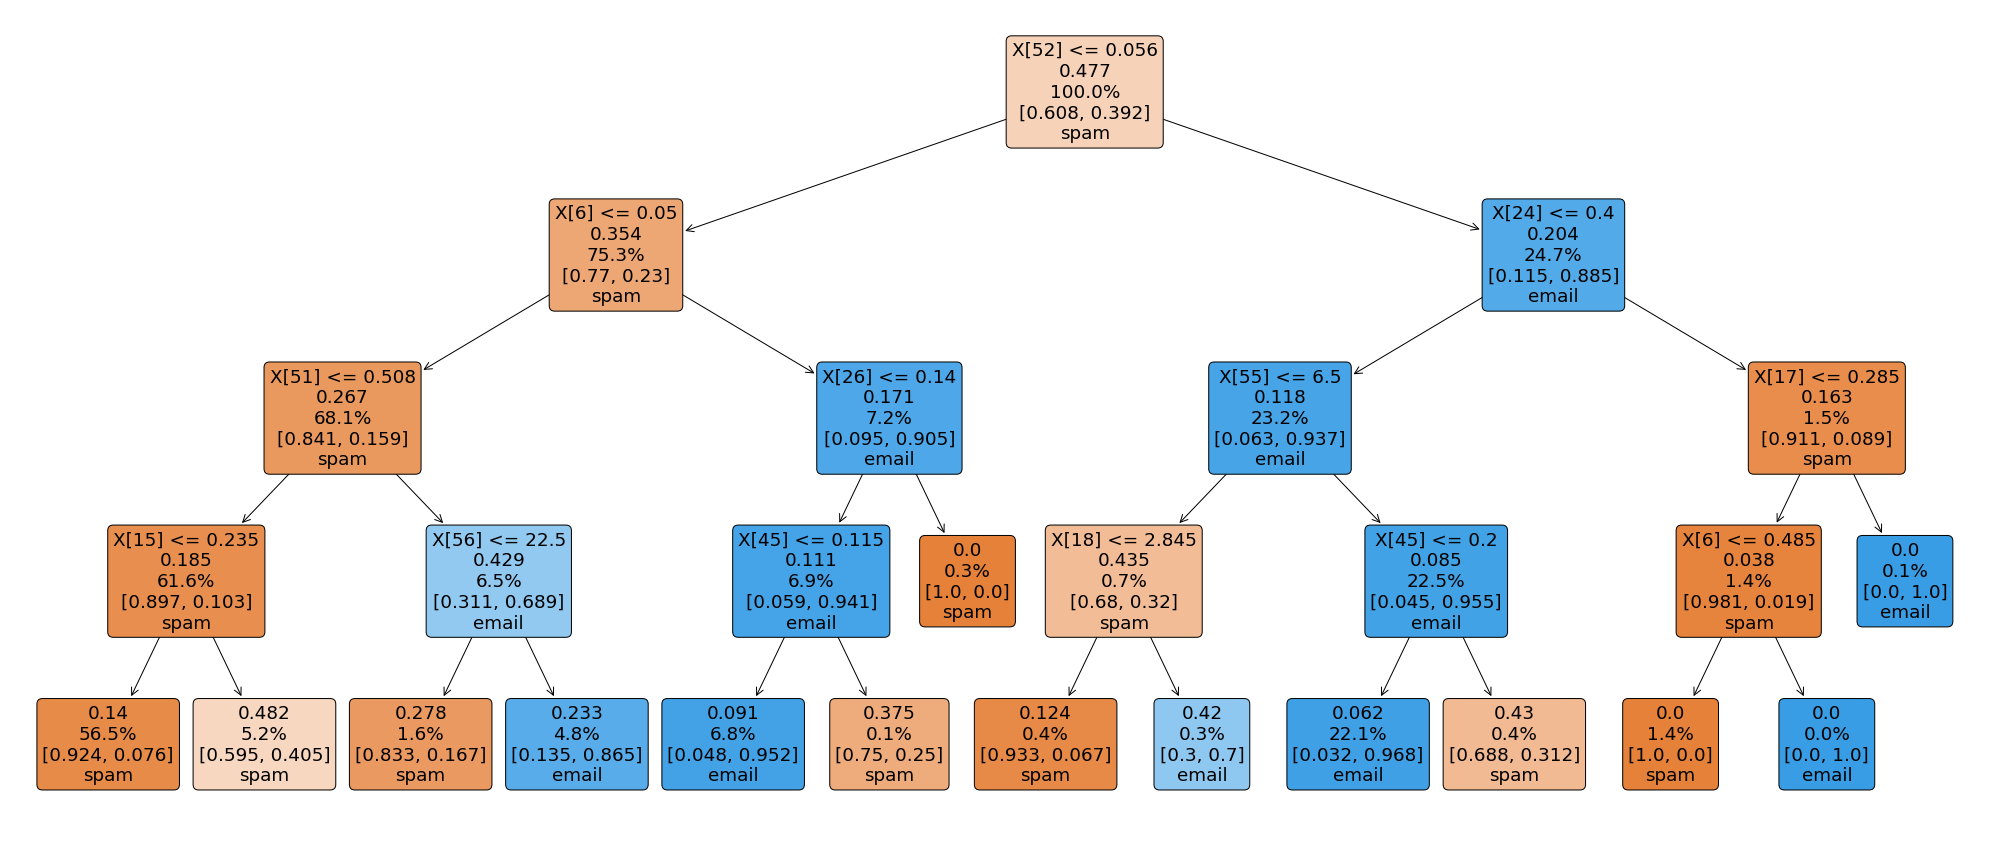

In [9]:
f = plt.figure(figsize=(35,15))
tree.plot_tree(clf, class_names=['spam', 'email'], proportion=True,
               rounded=True, filled=True, label='none');

#### Plotting an ROC curve for our decision tree

In [47]:
clf = tree.DecisionTreeClassifier(max_features=4)
clf = clf.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       550
           1       0.86      0.88      0.87       371

    accuracy                           0.89       921
   macro avg       0.89      0.89      0.89       921
weighted avg       0.90      0.89      0.89       921



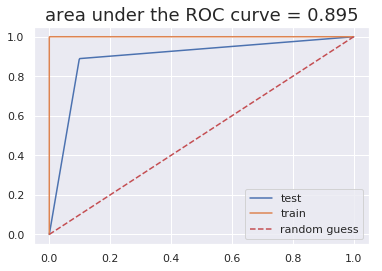

In [48]:
get_model_results(clf, X_train, X_test, y_train, y_test)

Calculating ROC curve for a random forest

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       550
           1       0.95      0.89      0.92       371

    accuracy                           0.93       921
   macro avg       0.94      0.93      0.93       921
weighted avg       0.94      0.93      0.93       921



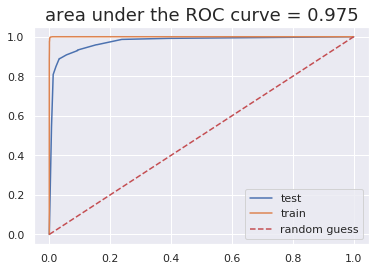

In [53]:
rf = RandomForestClassifier(n_estimators=10)
rf = rf.fit(X_train, y_train)
get_model_results(rf, X_train, X_test, y_train, y_test)

In [13]:
forest_dict = tree_auc(X_train, X_test, y_train, y_test)
tree_dict = tree_auc(X_train, X_test, y_train, y_test, types='decision_tree')

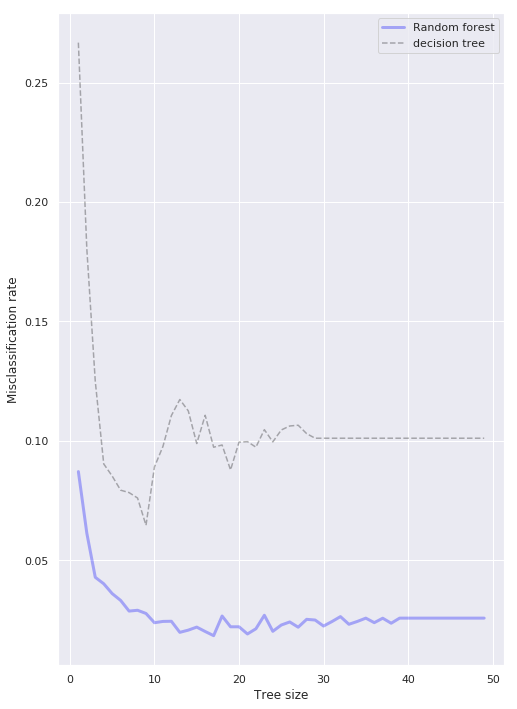

In [14]:
plot_tree_auc(forest_dict, tree_dict)